# Tohoku tsunami inversion
## Inversion using discrete adjoint with 130 basis functions

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
from time import clock

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse, rotation_matrix

_[Misc plotting functions]_

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        try:
            plot_field(field, fig, axes[i])
        except AttributeError:
            plot_mesh(field, fig, axes[i])
    return axes

In [7]:
level = 0
# level = 1
# level = 2

op = TohokuOptions(level=level)
op.gauges.pop('21418')  # This pressure gauge isn't within the domain

mesh = op.default_mesh
R = FunctionSpace(mesh, "R", 0)

boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

### Forward model

As before, consider the shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Assume zero initial velocity and expand the initial surface over a radial basis:

$$
    \mathbf u|_{t=0}\equiv\boldsymbol0,\qquad
    \eta|_{t=0}=\sum_{k=1}^N m_kg_k,
$$

where $m_k$ are (constant in space) control parameters and $g_k$ are Gaussians.

In [8]:
basis_region_centre = np.array([0.7e+06, 4.2e+06])
extent_x = 240.0e+03
extent_y = 560.0e+03
Nx = 10
Ny = 13
angle = -pi/12

In [9]:
N = Nx*Ny
basis_centres = []
Rtheta = rotation_matrix(angle)
for i in range(Nx):
    basis_centre_x = i*extent_x/(Nx-1) - 0.5*extent_x
    for j in range(Ny):
        basis_centre_y = j*extent_y/(Ny-1) - 0.5*extent_y
        basis_centres.append(tuple(basis_region_centre + np.dot(Rtheta, np.array([basis_centre_x, basis_centre_y]))))

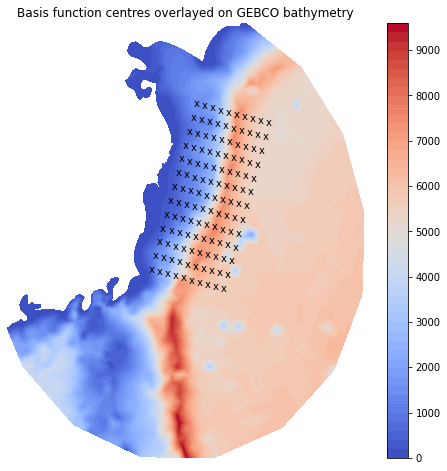

In [10]:
P1 = FunctionSpace(mesh, "CG", 1)
b = Function(P1, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(P1))

fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(tricontourf(b, axes=axes, cmap='coolwarm', levels=50), ax=axes)
axes.axis('off')
for loc in basis_centres:
    axes.annotate('x', xy=loc)
axes.set_title("Basis function centres overlayed on GEBCO bathymetry");

Setup for the initial condition

In [11]:
def get_basis_functions(fs, skew=(24e+03, 48e+03)):
    """
    Define an array of radial basis functions, each of which is a skewed Gaussian. The array is rotated
    about its centre by the (global) `angle` parameter.
    
    :arg fs: the mixed function space in which the initial condition will live.
    :kwarg skew: a tuple describing the extents to which the basis functions are skewed in the rotated axes.
    """
    basis_functions = []
    for loc in basis_centres:
        basis_function = Function(fs)
        psi, phi = basis_function.split()
        phi.interpolate(gaussian([loc + xy_skew, ], fs.mesh(), rotation=angle))
        basis_functions.append(basis_function)
    return basis_functions

In [59]:
def set_basis_coefficients(values):  # TODO: Allow set as array
    """
    Create an array of `Function`s which live in the R-space (of spatial constants) and initialise
    with the provided `values`.
    """
    basis_coefficients = [Function(R) for k in range(N)]
    if isinstance(values, (float, int)):
        values = [values for k in range(N)]
    assert len(values) == N
    for k, val in enumerate(values):
        basis_coefficients[k].assign(val)
    return basis_coefficients

In [48]:
def set_initial_condition(coeffs, fs):
    """
    Construct the propsed initial condition from the basis functions and the proposed coefficients.
    
    Note that if we try and sum all 130 components at once then we get a `maximum recursion depth
    exceeded` error in UFL due to the nested sum. To get around this we just do the sum in two parts.
    
    :arg coeffs: the proposed basis coefficients, expressed as a list.
    :arg fs: the mixed function space in which the initial condition will live.
    """
    basis_functions = get_basis_functions(fs)
    ic = Function(fs)
    tmp = Function(fs)
    ic.project(sum(m*phi for m, phi in zip(coeffs[:N//2], basis_functions[:N//2])))
    tmp.project(sum(m*phi for m, phi in zip(coeffs[N//2:], basis_functions[N//2:])))
    ic.assign(ic + tmp)
    return ic

In [13]:
def get_fields(fs):
    """
    Define fields associated with the physical model, as well as the gravitational acceleration constant.
      
    :arg fs: the mixed function space used to solve the forward problem. The bathymetry and the Coriolis
        parameter are taken to live in the associated elevation space.
    """
    elev_space = fs.sub(1)
    b = Function(elev_space, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(elev_space))
    f = Function(elev_space, name="Coriolis parameter").assign(op.set_coriolis(elev_space))
    g = Constant(op.g)
    return b, f, g

### Quantity of Interest

Again, we have the QoI

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathbb1_g$ is an indicator function related to a sufficiently small neighbourhood of gauge $g$.

In [14]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
    return scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')

In [27]:
def solve_forward(m):
    """
    Solve the linearised shallow water equations for an array of control parameters, `m`.
    
    :arg m: the array of control parameters, which should have dimension `N`.
    """
    print("FORWARD SOLVE")
    if isinstance(m, Function):
        m = [m, ]
    
    # --- Setup function spaces
    
    fs = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    P0 = FunctionSpace(mesh, "DG", 0)
    
    # -- Setup fields
    
    b, f, g = get_fields(fs)
    
    # --- Setup PDE
    
    dtc = Constant(op.dt)
    
    u, eta = TrialFunctions(fs)
    z, zeta = TestFunctions(fs)

    q_ = Function(fs)
    u_, eta_ = q_.split()

    a = inner(z, u)*dx + inner(zeta, eta)*dx
    L = inner(z, u_)*dx + inner(zeta, eta_)*dx
    
    n = FacetNormal(mesh)

    def G(uv, elev):
        F = g*inner(z, grad(elev))*dx
        F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
        F += -inner(grad(zeta), b*uv)*dx
        for tag in boundary_conditions:
            if 'freeslip' not in boundary_conditions[tag]:
                F += inner(zeta*n, b*uv)*ds(tag)
        return F

    a += 0.5*dtc*G(u, eta)
    L += -0.5*dtc*G(u_, eta_)

    q = Function(fs)
    u, eta = q.split()

    bcs = []
    for tag in boundary_conditions:
        if 'dirichlet' in boundary_conditions[tag]:
            bcs.append(DirichletBC(fs.sub(1), 0, tag))

    params = {
        "snes_type": "ksponly",
        "ksp_type": "gmres",
        "pc_type": "fieldsplit",
        "pc_fieldsplit_type": "multiplicative",
    }

    problem = LinearVariationalProblem(a, L, q, bcs=bcs)
    solver = LinearVariationalSolver(problem, solver_parameters=params)
    
    # --- Setup initial condition / control
    
    basis_functions = get_basis_functions(fs)
    try:
        assert len(basis_functions) == N
        assert len(m) == N
    except AssertionError:
        msg = "Number of basis functions and number of basis coefficients do not match ({:d} vs {:d})"
        raise ValueError(msg.format(len(basis_functions), len(m)))
        
    q_.assign(set_initial_condition(m, fs))
    
    # --- Setup QoI
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
        op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=60 if gauge[0] == 'P' else 1)
        
    op.end_time = 1440.0
        
    times = []

    # --- Time integrate
    
    t = 0.0
    iteration = 0
    J = 0
    eta_obs = Constant(0.0)
    weight = Constant(1.0)
    tic = clock()
    msg = "    simulation time {:4.1f} minutes    wallclock time {:4.1f} seconds"
    while t < op.end_time:
        times.append(t)
        if iteration % 48 == 0:
            toc = clock() - tic
            print(msg.format(t/60, toc))
            tic = clock()

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        weight.assign(0.5 if np.allclose(t, 0.0) else 1.0)
        u, eta = q.split()
        for gauge in op.gauges:
            indicator = op.gauges[gauge]['indicator']

            # Interpolate observations
            obs = float(op.gauges[gauge]['interpolator'](t))
            eta_obs.assign(obs)

            # Continuous form of error
            J += assemble(weight*dtc*0.5*indicator*(eta - eta_obs)**2*dx)

        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
    toc = clock() - tic
    print(msg.format(t/60, toc))
    print("    Quantity of interest = {:.8e}".format(J))
    
    weight.assign(0.5)
    u, eta = q.split()
    for gauge in op.gauges:
        indicator = op.gauges[gauge]['indicator']

        # Interpolate observations
        obs = float(op.gauges[gauge]['interpolator'](t))
        eta_obs.assign(obs)

        # Continuous form of error
        J += assemble(weight*dtc*0.5*indicator*(eta - eta_obs)**2*dx)
    
    return J, q

In [17]:
def reduced_functional(m, **kwargs):
    J, q = solve_forward(m)
    try:
        controls = [Control(mi) for mi in m]
    except IndexError:
        controls = Control(m)
    return ReducedFunctional(J, controls, **kwargs)

Set an initial guess

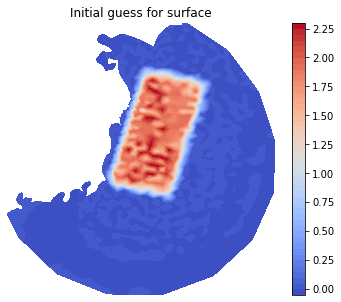

In [28]:
tape = get_working_tape()
tape.clear_tape()
basis_coefficients = set_basis_coefficients(1.0)
with stop_annotating():
    TaylorHood = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    initial_guess = set_initial_condition(basis_coefficients, TaylorHood)
    initial_guess_u, initial_guess_eta = initial_guess.split()
    initial_guess_eta.dat.name = "Initial guess for surface"
    plot_field(initial_guess_eta);

Let's take a look at the forward solution.

FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 13.5 seconds
    simulation time  8.0 minutes    wallclock time 14.2 seconds
    simulation time 12.0 minutes    wallclock time 14.8 seconds
    simulation time 16.0 minutes    wallclock time 14.5 seconds
    simulation time 20.0 minutes    wallclock time 15.1 seconds
    simulation time 24.0 minutes    wallclock time 14.9 seconds
    Quantity of interest = 4.58346337e+13


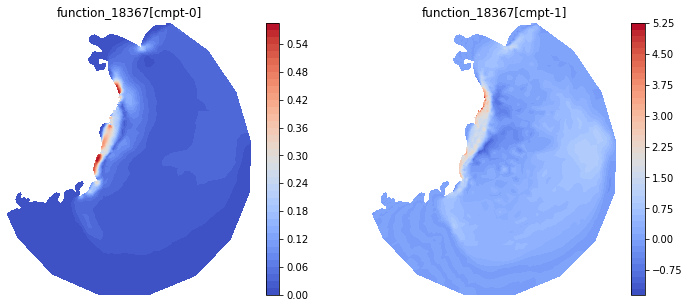

In [29]:
J, q = solve_forward(basis_coefficients)
plot_fields(*q.split());

In [30]:
controls = [Control(m) for m in basis_coefficients]
g = compute_gradient(J, controls)

Let's take a look at the adjoint solution.

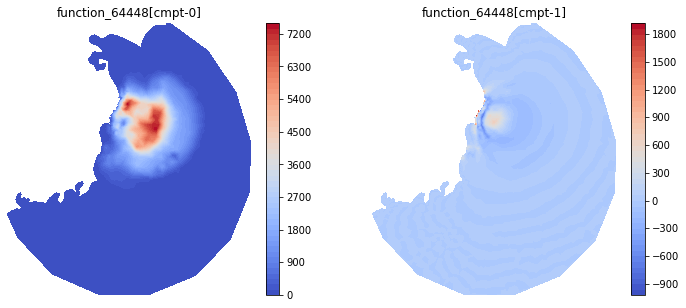

In [31]:
tape = get_working_tape()
blocks = tape.get_blocks()
solve_blocks = [block for block in blocks if isinstance(block, GenericSolveBlock)]
q_star0 = solve_blocks[0].adj_sol
plot_fields(*q_star0.split());

## Taylor Test

To check that the gradient is consistent, we can apply a Taylor remainder test.
Denote by $\widehat J=\widehat J(m)$ the reduced functional and consider the first order Taylor remainder

$$
    T_1(h):=\left|\:\widehat J(m+h\delta m) - \widehat J(m)\:\right|,
$$

for some search direction $\delta m$ and step length $m$.
In addition, consider the second order Taylor remainder

$$
    T_2(h):=\left|\:\widehat J(m+h\delta m) - \widehat J(m) - h\;\mathrm d\widehat J\cdot\delta m\:\right|.
$$

where we propose that $\mathrm d\widehat J$ is the gradient of $\widehat J$ w.r.t. the control $m$.
Continuity of the reduced functional implies that $\lim_{h\rightarrow0}T_1(h)=0$ at rate $\mathcal O(h)$.
Provided that $\mathrm d\widehat J$ is indeed the gradient, we also have that $\lim_{h\rightarrow0}T_2(h)=0$.
Moreover, we expect that this convergence is achieved at rate $\mathcal O(h^2)$.

The Taylor test simply verifies that the second order convergence is achieved.

In [41]:
def taylor_test(m_init, h_init=1):
    print(20*"=" + "TAYLOR TEST" + 20*"=")
    tape = get_working_tape()
    tape.clear_tape()
    
    # Set control parameter values
    m = set_basis_coefficients(m_init)

    # Choose a random search direction
    delta_m = np.random.rand(N)
    
    # Evaluate the reduced functional and gradient at the specified control value
    Jm = solve_forward(m)[0]
    dJm = compute_gradient(Jm, [Control(mi) for mi in m])
    dJm = np.array([dJm_i.dat.data for dJm_i in dJm])
    m = np.array([m_i.dat.data for m_i in m])
    tape.clear_tape()
    
    # Check that the Taylor remainders decrease quadratically
    with stop_annotating():
        remainders = np.zeros(3)
        for i in range(3):
            h = h_init*pow(0.5, i)
            print("h = {:.4e}".format(h))
            J_step = solve_forward(m+h*delta_m)[0]
            remainders[i] = abs(J_step - Jm - h*np.dot(dJm, delta_m))
            print("Taylor remainder = {:.4e}".format(remainders[i]))
            if i > 0:
                ratio = remainders[i-1]/remainders[i]
                try:
                    assert ratio > 1.95
                except AssertionError:
                    msg = "Taylor remainders do not decrease quadratically (ratio {:.4e})"
                    raise ConvergenceError(msg.format(ratio))
    print(16*"=" + "TAYLOR TEST PASSED!" + 16*"=")

In [42]:
taylor_test(1.0)

====================TAYLOR TEST====================
FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 17.5 seconds
    simulation time  8.0 minutes    wallclock time 19.5 seconds
    simulation time 12.0 minutes    wallclock time 18.8 seconds
    simulation time 16.0 minutes    wallclock time 17.9 seconds
    simulation time 20.0 minutes    wallclock time 18.5 seconds
    simulation time 24.0 minutes    wallclock time 18.5 seconds
    Quantity of interest = 4.58346337e+13
h = 1.0000e+00
FORWARD SOLVE


ValueError: operands could not be broadcast together with shapes (130,) (3,) 

## Inversion for 130 basis function coefficients

Now that we have functions for solving the forward problem and computing the gradient, we can apply a quasi-Newton optimisation method such as BFGS to optimise the control parameter.

In [43]:
def derivative_cb_post(j, dj, m):
    print("functional  {:.8e}".format(j))
#     print("control {:}  functional  {:.8e}  gradient {:}".format(m, j, dj))

opt_parameters = {
    'maxiter': 5,
    'disp': True,
#     'gtol': 1.0e-02,
    'gtol': 1.0,
}

tape = get_working_tape()
tape.clear_tape()

# Set initial guesses for controls
m = set_basis_coefficients(1.0)

# Evaluate the reduced functional
J = reduced_functional(m, derivative_cb_post=derivative_cb_post)

# Call the optimisation routine
m_opt = minimize(J, method='BFGS', options=opt_parameters)

FORWARD SOLVE
functional  4.59168121e+13
functional  4.34276403e+13
functional  3.99449831e+13
functional  3.71103691e+13
functional  3.44353199e+13
functional  3.24589766e+13
         Current function value: 32458976629573.285156
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


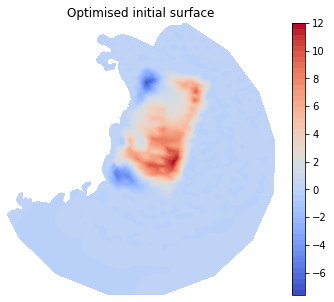

In [51]:
with stop_annotating():
    TaylorHood = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    ic_opt = set_initial_condition(m_opt, TaylorHood)
    ic_opt_u, ic_opt_eta = ic_opt.split()
    ic_opt_eta.dat.name = "Optimised initial surface"
    plot_field(ic_opt_eta);

We didn't reach convergence in the mere 5 iterations so let's carry on from where we left off.

In [52]:
m_opt_saved = [m_opt_i.dat.data[0] for m_opt_i in m_opt]

In [ ]:
opt_parameters = {
    'maxiter': 20,
    'disp': True,
#     'gtol': 1.0e-02,
    'gtol': 1.0,
}

tape = get_working_tape()
tape.clear_tape()

# Set initial guesses for controls
m = set_basis_coefficients(m_opt_saved)

# Evaluate the reduced functional
J = reduced_functional(m, derivative_cb_post=derivative_cb_post)

# Call the optimisation routine
m_opt = minimize(J, method='BFGS', options=opt_parameters)